# Proyecto E1: Entender los datos

**Por:    Grupo 7**

Proyecto de consultoria de RaSa, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Objetivo

- Explorar y analizar fuentes de datos (entendimiento de datos) relacionadas con el proyecto del curso.
- Inspeccionar el nivel de calidad de las fuentes de datos provistas.
- Revisar la viabilidad de implementar análisis con fuentes de datos dadas.


## Enunciado RaSa
RaSA de forma conjunta con un grupo de consultores de inteligencia de negocios, ha trabajado en una especificación de los primeros análisis que quiere que usted realice. En esta primera fase, a partir de estos análisis propuestos, la empresa le ha entregado una serie de fuentes de datos y requiere que usted realice los siguientes entregables relacionados con la etapa de entendimiento de datos:

- Entregable 1 - Perfilamiento de datos: Explore las fuentes de datos compartidas y analice el resultado.

- Entregable 2 - Análisis de calidad de datos: Revise las 4 dimensiones de calidad vistas en el curso en las fuentes compartidas y saque conclusiones.

- Entregable 3- Conclusión del entendimiento de datos: Valide y documente si es posible realizar los análisis solicitados, si debe hacer ajustes en la forma como han sido planteados o si requiere de información adicional para el desarrollo de los mismos. En caso de ser posible, indique explicitamente las columnas que permiten relacionar los registros de las diferentes fuentes para poder integrarlas y no olvide incluir la lista de supuestos y dudas que quedan luego de este ejercicio para que sea la empresan quien de respuesta a esas inquietudes.

Recuerde que la exploración de los datos depende de los objetivos que tenga el proyecto de analítica. Es así como RaSA le comparte ejemplos de análisis que en este momento está interesado en responder, documentados en la matriz de temas analíticos, donde se encuentra, adicional a los análisis identificados (ver la columna análisis requeridos), los datos requeridos para lograr los objetivos del proyecto.

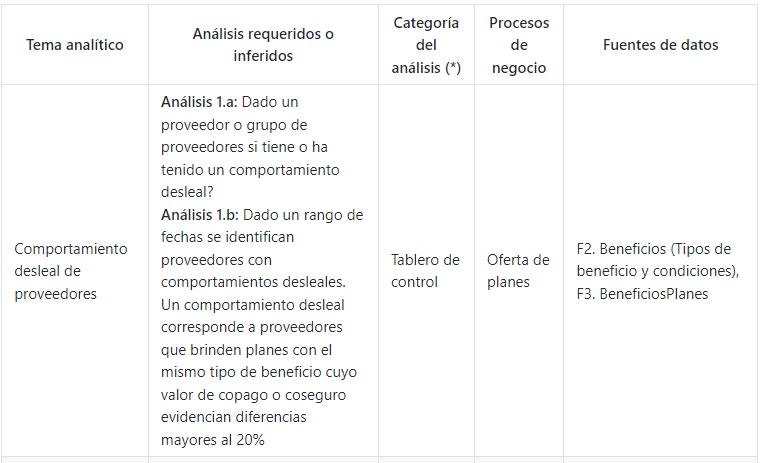

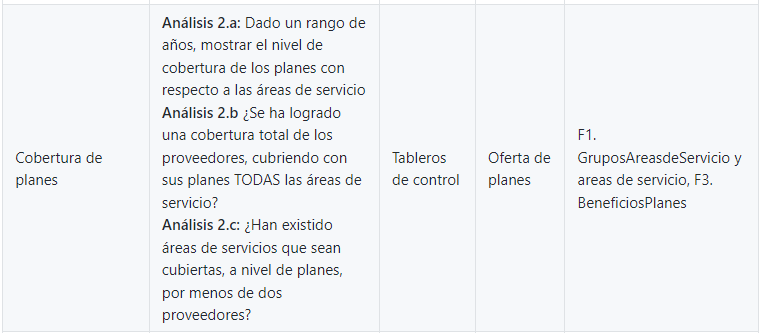


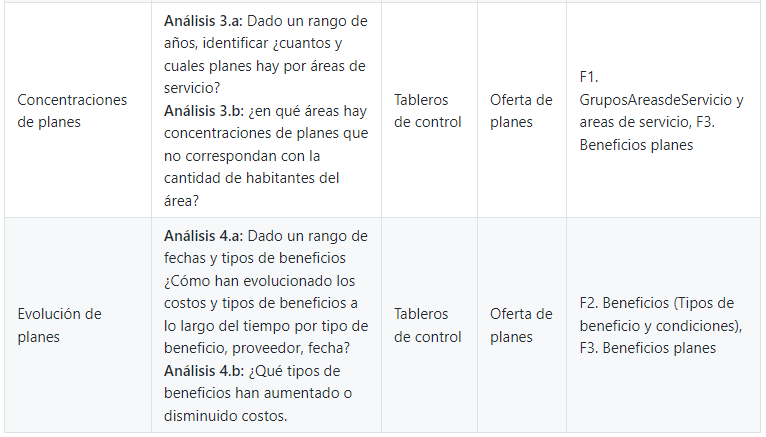

*La categoría de análisis posibles son Tableros de control, Análisis OLAP, Aprendizaje automático, Consultas SQL. En el curso solo vamos a abordar los tableros de control

** Los análisis de la tabla pueden ser agrupaciones de análisis más pequeños o se pueden extender, incluso puede que los análisis no estén completos. Es libre de proponerle nuevos análisis al negocio o complementar los de la tabla como parte de sus conclusiones. Piense en qué, le beneficiaría más a RaSA y en particular a un usuario que esté interesado en este estilo de análisis.

Para esta actividad de entender los datos, la empresa les comparte los siguientes grupos de fuentes de datos y las respectivas tablas:

F1. AreasdeServicio: FuenteAreasDeServicio_Copia_E

F2. TiposBeneficios: FuenteTiposBeneficio_Copia_E

F3. BeneficiosPlanes: FuentePlanesBeneficio_Copia_E

F4. Tablas de referencia: FuenteCondicionesDePago_Copia_E

Dichos datos pueden tener errores ya que no han sido utilizados previamente para ser analizados. La empresa nos da información adicional sobre los datos:

1. Las áreas de servicios reportadas cubren todos los condados del país
2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.
3. Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019
4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.
5. El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100.
6. Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018.
7. Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [3]:
#!pip install pyspark_dist_explore

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np
from pyspark_dist_explore import hist, distplot

Configuración del controlador e inicio de sesion Spark

In [5]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-j-8.0.31.jar'

In [6]:
#Configuración de la sesión
try:
    spark
except:
    conf=SparkConf() \
        .set('spark.driver.extraClassPath', path_jar_driver)

    spark_context = SparkContext(conf=conf)
    sql_context = SQLContext(spark_context)
    spark = sql_context.sparkSession

C:\Spark\spark-3.3.1-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_47_202215'
db_psswd = 'AaBb1122'

PATH='./'

## Perfilamiento de los datos

### Conexión a fuente de datos y acceso a los datos

In [8]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos

In [9]:
#Se cargan los dataframes desde la base de datos
sql_condiciones_pago = 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E'
sql_tipos_beneficio = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'
sql_planes_beneficio = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'
sql_areas_servicio = 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E'

condiciones_pago = obtener_dataframe_de_bd(db_connection_string, sql_condiciones_pago, db_user, db_psswd)
tipos_beneficio = obtener_dataframe_de_bd(db_connection_string, sql_tipos_beneficio, db_user, db_psswd)
planes_beneficio = obtener_dataframe_de_bd(db_connection_string, sql_planes_beneficio, db_user, db_psswd)
areas_servicio = obtener_dataframe_de_bd(db_connection_string, sql_areas_servicio, db_user, db_psswd)

### Entendimiento general de datos

In [10]:
condiciones_pago.show(3)

+---------------------+--------------------+--------+
|IdCondicionesDePago_T|         Descripcion|    Tipo|
+---------------------+--------------------+--------+
|                  187|Copay with deduct...|  Copago|
|                  204|       Copay per Day|  Copago|
|                   45|         Coinsurance|Coseguro|
+---------------------+--------------------+--------+
only showing top 3 rows



In [11]:
tipos_beneficio.show(3)

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|                    |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              795|Rehabilitative Sp...|Days per Benefit ...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes| 2

In [12]:
planes_beneficio.show(3)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

In [13]:
areas_servicio.show(3)

+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct| Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|         100622017|New Jersey - Medi...|        34005|Burlington County|New Jersey|    464269.0|805.0|   577.0| 2017|
|         101012018|New Jersey - Medi...|        34031|   Passaic County|New Jersey|    518117.0|185.0|  2801.0| 2018|
|          10132017|BlueOptions16842F...|        12031|     Duval County|   Florida|    999935.0|774.0|  1292.0| 2017|
+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
only showing top 3 rows



*Esquema de la base de datos obtenido por ingeniería inversa usando MySQLWorkbench:*

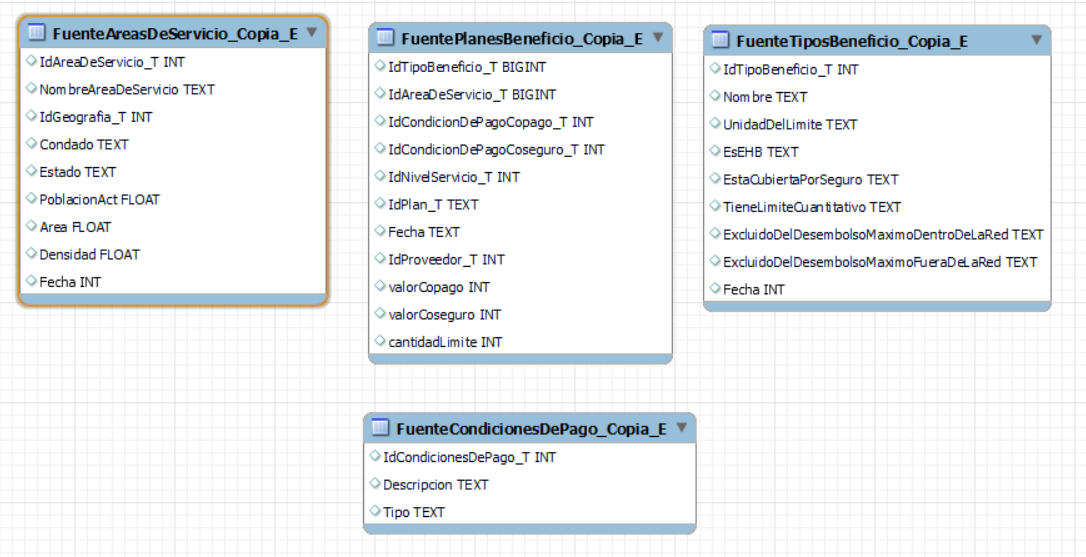



Se puede observar que la base de datos RaSaTransaccional contiene 4 grupos de fuentes de datos que corresponden aparentemente con los campos definidos en el diccionario. 

De acuerdo con la revisión de las tablas, el diccionario de datos y el diagrama obtenido de la base de datos usando MySQLWorkBench podemos concluir que la tabla de hechos es FuentePlanesBeneficio_Copia_E en donde se cuenta con información relacionada con los beneficios adquiridos en un plan de salud que se quiere analizar para lo cual nos proporcionan identificadores del tipo de beneficio del plan, el área de servicio del beneficio del plan y las condiciones de los beneficios del plan, además contiene medidas relacionadas con los valores de pago de los beneficios del plan y la cantidad limite del tipo de beneficio del plan. También se cuenta con la fecha de oferta del beneficio para ese plan.


Hallazgos y aclaraciones a solicitar al negocio:
- La fecha no se encuentra como una dimensión sino como un atributo de la tabla de hechos.
- Tenemos variables que van a requerir ser cambiadas en su tipo de categorica a numerica para posteriores análisis. Por ejemplo UnidadDelLimite de la tabla FuenteTiposBeneficio_Copia_E.
- En la tabla de hechos FuentePlanesBeneficio_Copia_E se identifican dos referencias a fuentes de datos faltantes para IdNivelServicio y IdProveedor. Se solicita al negocio proveer dicha información o aclarar el por qué faltan. 
- Adicionalmente se tiene la duda del significado del Coseguro que involucra las variables (valorCoseguro, IdCondicionDePagoCoseguro_T) de la tabla FuentePlanesBeneficio_Copia_E. Se solicita aclaración al negocio.
- ¿Por qué si en el diccionario de datos aparecen las restricciones de claves principales y foraneas, al hacer ingeniería inversa de la base de datos y validar en el inspector de tablas, ninguna tiene restricciones de llaves foraneas (FK) y todos los campos pueden ser null, incluyendo el identificador principal (PK)?
- ¿Por qué los mismos identificadores en diferentes tablas salen con diferentes nombres y diferentes tipos?

*Esquema de la tabla de hechos FuentePlanesBeneficio_Copia_E:*

In [14]:
planes_beneficio.schema

StructType([StructField('IdTipoBeneficio_T', LongType(), True), StructField('IdAreaDeServicio_T', LongType(), True), StructField('IdCondicionDePagoCopago_T', IntegerType(), True), StructField('IdCondicionDePagoCoseguro_T', IntegerType(), True), StructField('IdNivelServicio_T', IntegerType(), True), StructField('IdPlan_T', StringType(), True), StructField('Fecha', StringType(), True), StructField('IdProveedor_T', IntegerType(), True), StructField('valorCopago', IntegerType(), True), StructField('valorCoseguro', IntegerType(), True), StructField('cantidadLimite', IntegerType(), True)])

In [15]:
planes_beneficio.distinct().count()

27543

In [16]:
planes_beneficio.groupBy("idTipoBeneficio_T").count().show(5)

+-----------------+-----+
|idTipoBeneficio_T|count|
+-----------------+-----+
|             1950|   30|
|             1010|   25|
|               65|    1|
|             1840|   31|
|             1360|   22|
+-----------------+-----+
only showing top 5 rows



En la celda anterior se buscaba identificar la granularidad de la tabla de hechos en donde pareciera que cada registro hace referencia a un beneficio particular de un mismo plan definido por IdPlan_T.

**¿Qué es una fila de cada fuente compartida?**
- FuenteAreasDeServicio_Copia_E --> Una fila de esta tabla representa una zona geográfica sobre la cuál se puede tener cobertura en un beneficio. Un registro tiene información identificador del área, su nombre, la fecha de creación, el identificador del condado, los nombres del estado y del condado e información de población, área y densidad de habitantes de la cobertura.
- FuenteCondicionesDePago_Copia_E --> Una fila de esta tabla representa el tipo de pago y la descripción de las condiciones del pago. 
- FuentesPlanesBeneficio_Copia_E --> Una fila de esta tabla representa un beneficio asociado a un plan y unas caracteristicas del beneficio como el tipo, el area de servicio, las condiciones de copago y coseguro, el proveedor que lo suministra, el nivel de servicio, la fecha de oferta del beneficio para ese plan, los valores de copago y coseguro y la cantidad limite del tipo de beneficio.
- FuenteTiposBeneficio_Copia_E --> Una fila de esta tabla representa el tipo de beneficio, su nombre, la unidad límite y si la tiene, si se cubre dentro de la red, si esta excluido del desembolso dentro o fuera de la red y las condiciones de este beneficio (si es escencial, lo cubre el seguro, etc.)


In [17]:
lista_tablas = {"FuenteAreasDeServicio_Copia_E":areas_servicio, "FuenteTiposBeneficio_Copia_E":tipos_beneficio, "FuentesPlanesBeneficio_Copia_E":planes_beneficio, "FuenteCondicionesDePago_Copia_E":condiciones_pago}

for k,v in lista_tablas.items():
    print(f"TABLA: {k}")
    print(f" --> TIPOS DE DATOS: ", v.schema)
    print("-"*100)

TABLA: FuenteAreasDeServicio_Copia_E
 --> TIPOS DE DATOS:  StructType([StructField('IdAreaDeServicio_T', IntegerType(), True), StructField('NombreAreaDeServicio', StringType(), True), StructField('IdGeografia_T', IntegerType(), True), StructField('Condado', StringType(), True), StructField('Estado', StringType(), True), StructField('PoblacionAct', DoubleType(), True), StructField('Area', DoubleType(), True), StructField('Densidad', DoubleType(), True), StructField('Fecha', IntegerType(), True)])
----------------------------------------------------------------------------------------------------
TABLA: FuenteTiposBeneficio_Copia_E
 --> TIPOS DE DATOS:  StructType([StructField('IdTipoBeneficio_T', IntegerType(), True), StructField('Nombre', StringType(), True), StructField('UnidadDelLimite', StringType(), True), StructField('EsEHB', StringType(), True), StructField('EstaCubiertaPorSeguro', StringType(), True), StructField('TieneLimiteCuantitativo', StringType(), True), StructField('Exclu

In [18]:
for k,v in lista_tablas.items():
    rows = v.count() 
    unicos = v.distinct().count()
    cols = len(v.columns)
    print("\033[1m"+f"TABLA: {k}"+"\033[0m")
    print('\033[1m'+f'Dimensión de {k}: {(rows,cols)}'+'\033[0m')
    print('\033[1m' +"Las dimensiones de los datos trabajados son:"+'\033[0m')
    print("Número de filas: " + str(rows)) 
    print("Número únicos: " + str(unicos))
    print("Número duplicados: "+ str(rows-unicos))
    print("Número de columnas: " + str(cols))
    print("-"*100)
    v.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in v.columns]
   ).show()

TABLA: FuenteAreasDeServicio_Copia_E
Dimensión de FuenteAreasDeServicio_Copia_E: (188815, 9)
Las dimensiones de los datos trabajados son:
Número de filas: 188815
Número únicos: 145242
Número duplicados: 43573
Número de columnas: 9
----------------------------------------------------------------------------------------------------
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|Condado|Estado|PoblacionAct|Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
|              6288|                   0|         6378|      0|     0|           0|2407|    2407|    0|
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+

TABLA: FuenteTiposBeneficio_Copia_E
Dimensión de FuenteTiposBeneficio_Copia_E: (849, 9)
Las dimensiones de los datos trabajados son:
Número de fila

In [19]:
sql = "(SELECT * FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E ORDER BY IdTipoBeneficio_T, IdAreaDeServicio_T) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|             null|             82018|                      238|                         45|                3|10207VA0430006-01|2018-12-31|        10207|          0|          100|             1|
|             null|             82018|                      238|                         45|                3|10207VA0430006-01|2018-12-31|        10207|          0|          100|             1|
|             null|      

**¿Cuantos datos nos compartieron para el proyecto?**
- FuentesPlanesBeneficio_Copia_E --> En total tenemos 36.036 registros beneficios, de los cuales 27.543 son únicos, es decir, hay 8.493 registros duplicados y tenemos en total 11 variables a revisar; de las cuales según la estructura compartida son 2 cadenas de texto y el resto numéricas.
- FuenteAreasDeServicio_Copia_E --> En total tenemos 188.815 registros beneficios, de los cuales 145.242 son únicos, es decir, hay 43.573 registros duplicados y tenemos en total 9 variables a revisar; de las cuales según la estructura compartida son 3 cadenas de texto y el resto numéricas.
- FuenteCondicionesDePago_Copia_E --> En total tenemos 31 registros beneficios, de los cuales 24 son únicos, es decir, hay 7 registros duplicados y tenemos en total 3 variables a revisar; de las cuales según la estructura compartida son 2 cadenas de texto y 1 numérica.
- FuenteTiposBeneficio_Copia_E --> En total tenemos 849 registros beneficios, de los cuales 578 son únicos, es decir, hay 271 registros duplicados y tenemos en total 9 variables a revisar; de las cuales según la estructura compartida son 7 cadenas de texto y el resto numéricas.

En general se identificaron registros completos duplicados en todas las tablas. (Tabla de hechos eliminar)

### Revisión de reglas de negocio 

1. Las áreas de servicios reportadas corresponden a todas la áreas del país **-- Esta afirmación es falsa. Hay 1.398 Condados con áreas de servicio reportadas de 3.143 que posee Estados Unidos. Adicionalmente esta regla no se cumple al validar el número de Estados que reporta 35 de 50 que tiene Estados Unidos. --**

In [20]:
sql = "(SELECT count(distinct(Condado)) FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+------------------------+
|count(distinct(Condado))|
+------------------------+
|                    1398|
+------------------------+



In [21]:
sql = "(SELECT count(distinct(Estado)) FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------------------+
|count(distinct(Estado))|
+-----------------------+
|                     35|
+-----------------------+



2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen
**-- Esta afirmación es verdadera como se puede evidenciar en la siguiente consulta. (La cantidad mínima cuando hay límite cuantitativo es de 1) --** 

In [22]:
sql = "(SELECT min(cantidadLimite) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p INNER JOIN RaSaTransaccional.FuenteTiposBeneficio_Copia_E as t ON  p.IdTipoBeneficio_T = t.IdTipoBeneficio_T WHERE TieneLimiteCuantitativo = 'Yes') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-------------------+
|min(cantidadLimite)|
+-------------------+
|                  1|
+-------------------+



3. Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019
 **-- Esta afirmación es falsa pues para FuenteAreasDeServicio_Copia_E el rango de la fecha del año 1800 al año 2018 y para FuenteTiposBeneficio_Copia_E este mismo rango es del año 2017 al año 2018 --**

In [23]:
sql = "(SELECT  min(Fecha)  as min_fecha_area, max(Fecha)  as max_fecha_area FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+--------------+--------------+
|min_fecha_area|max_fecha_area|
+--------------+--------------+
|          1800|          2018|
+--------------+--------------+



In [24]:
sql = "(SELECT min(Fecha) as min_fecha_tipo, max(Fecha)  as max_fecha_tipo FROM RaSaTransaccional.FuenteTiposBeneficio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+--------------+--------------+
|min_fecha_tipo|max_fecha_tipo|
+--------------+--------------+
|          2017|          2018|
+--------------+--------------+



4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios. **-- Esta afirmación es verdadera para las áreas de servicio pero falsa para los tipos de beneficios ya que hay 178. --**

In [25]:
sql = "(SELECT count(distinct(IdAreaDeServicio_T)) FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------------------------------+
|count(distinct(IdAreaDeServicio_T))|
+-----------------------------------+
|                               5409|
+-----------------------------------+



In [26]:
sql = "(SELECT count(distinct(IdTipoBeneficio_T)) FROM RaSaTransaccional.FuenteTiposBeneficio_Copia_E) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+----------------------------------+
|count(distinct(IdTipoBeneficio_T))|
+----------------------------------+
|                               178|
+----------------------------------+



5. El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100. **-- Esta afirmación es verdadera para valor Coseguro y falsa para Copago en donde el valor máximo es de 3500 --**

In [27]:
sql = "(SELECT max(valorCopago), max(valorCoseguro) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE Fecha LIKE '%2018%') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+----------------+------------------+
|max(valorCopago)|max(valorCoseguro)|
+----------------+------------------+
|            3500|               100|
+----------------+------------------+



6. Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018. **-- Esta afirmación es falsa pues se tiene información de 203 planes para 2017 y 287 planes para 2018. --**

In [28]:
sql = "(SELECT count(distinct(IdPlan_T)) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE Fecha LIKE '%2017%') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-------------------------+
|count(distinct(IdPlan_T))|
+-------------------------+
|                      203|
+-------------------------+



In [29]:
sql = "(SELECT count(distinct(IdPlan_T)) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE Fecha LIKE '%2018%') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-------------------------+
|count(distinct(IdPlan_T))|
+-------------------------+
|                      287|
+-------------------------+



7. Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente. **-- Esta afirmación es falsa pues se tienen 19 y 7 condiciones de copago y coseguro respectivamente. --**

In [30]:
sql = "(SELECT Tipo, count(*) FROM RaSaTransaccional.FuenteCondicionesDePago_Copia_E GROUP BY Tipo) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-------------+--------+
|         Tipo|count(*)|
+-------------+--------+
|       Copago|      19|
|     Coseguro|       7|
|     Copagado|       1|
|SinTipoCopago|       1|
|          NaN|       2|
|  Coseguridad|       1|
+-------------+--------+



### Análisis descriptivo

In [31]:
for k,v in lista_tablas.items():
    print(f"TABLA: {k}")
    v.summary().show()
    print("-"*100)

TABLA: FuenteAreasDeServicio_Copia_E
+-------+--------------------+--------------------+------------------+----------------+-------+-------------------+------------------+-----------------+------------------+
|summary|  IdAreaDeServicio_T|NombreAreaDeServicio|     IdGeografia_T|         Condado| Estado|       PoblacionAct|              Area|         Densidad|             Fecha|
+-------+--------------------+--------------------+------------------+----------------+-------+-------------------+------------------+-----------------+------------------+
|  count|              182527|              188815|            182437|          188815| 188815|             188815|            186408|           186408|            188815|
|   mean|5.5661602010935366E7|                null| 42946.06266820875|            null|   null|4.147959051463602E7| 770.9518851122269|276.0979410754903|2010.2215554908244|
| stddev|3.0402410466496132E7|                null|32489.478070072095|            null|   null|5.943835

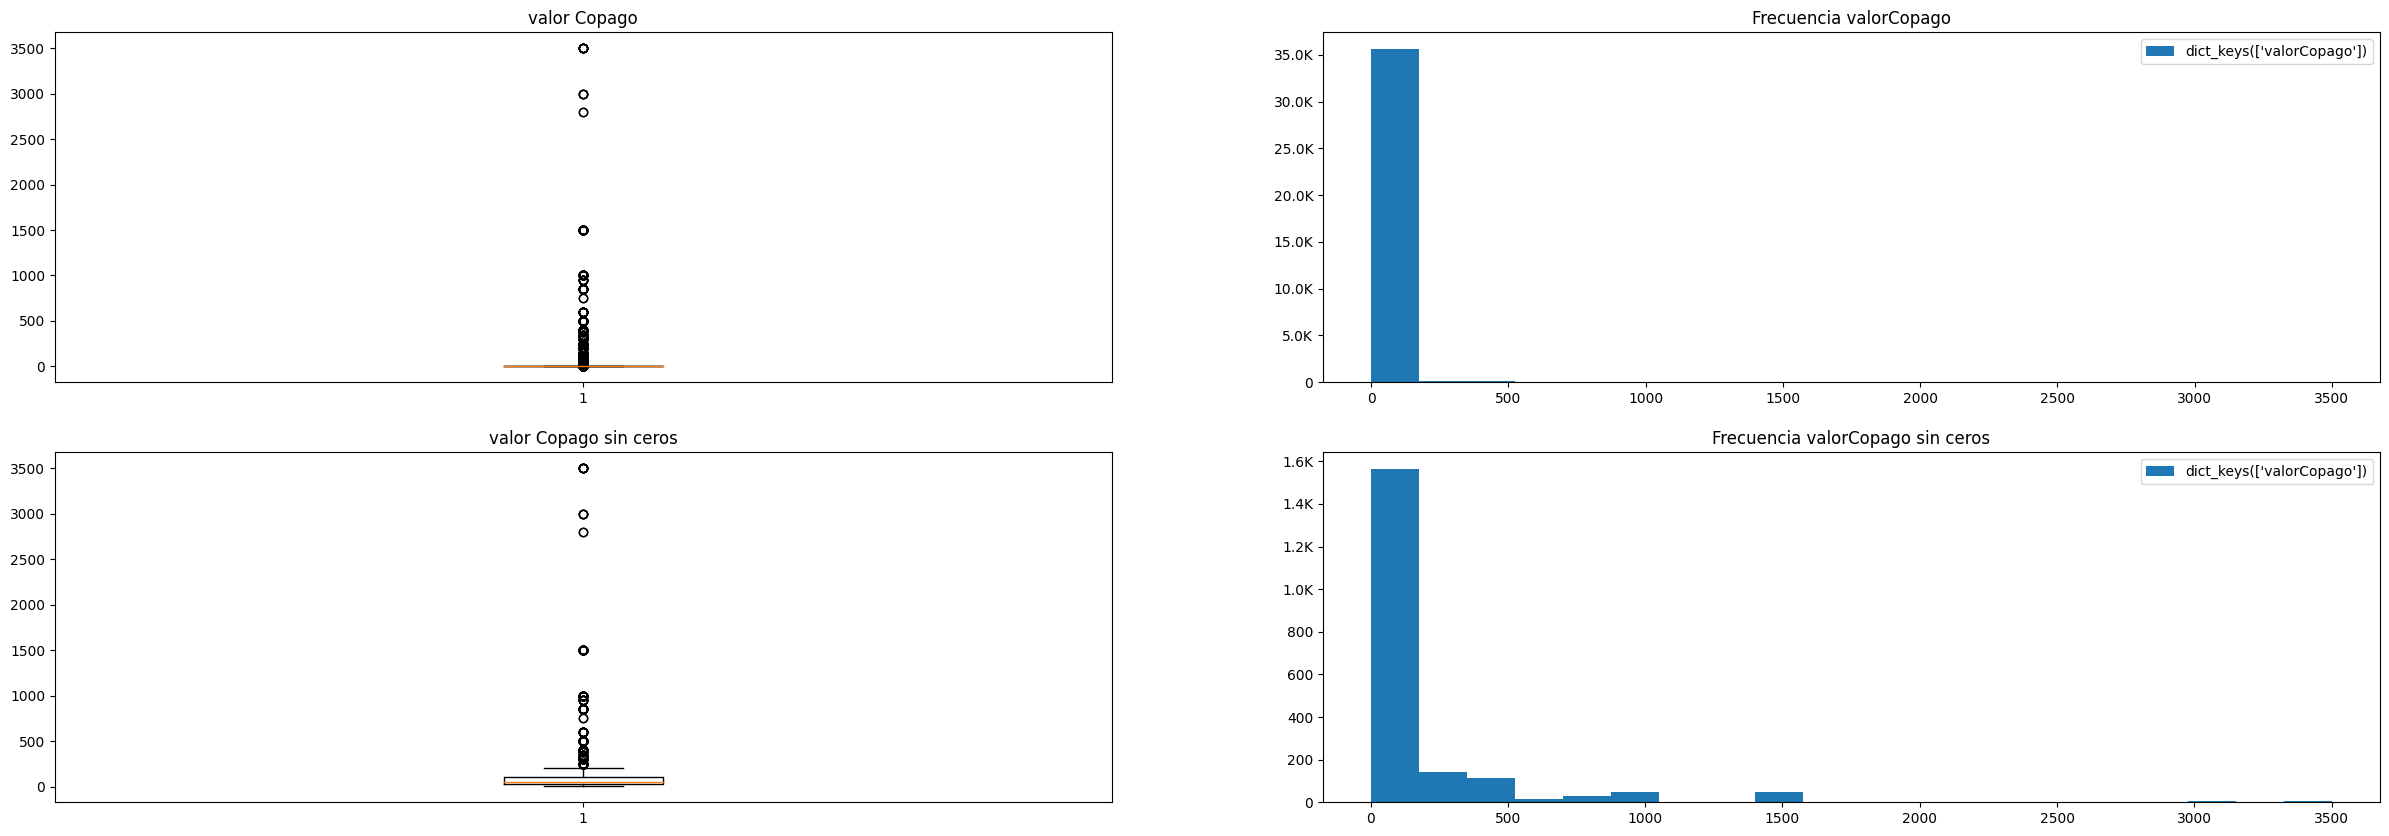

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(30, 10)
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

ax1.set_title('valor Copago')
ax1.boxplot(np.array(planes_beneficio.select('valorCopago').collect()))

hist(ax2, planes_beneficio.select('valorCopago'), bins = 20)
ax2.set_title('Frecuencia valorCopago')
ax2.legend()

ax3.set_title('valor Copago sin ceros')
ax3.boxplot(np.array(planes_beneficio.select('valorCopago').where(col('valorCopago') > 0).collect()))

hist(ax4, planes_beneficio.select('valorCopago').where(col('valorCopago') > 0), bins = 20)
ax4.set_title('Frecuencia valorCopago sin ceros')
ax4.legend()

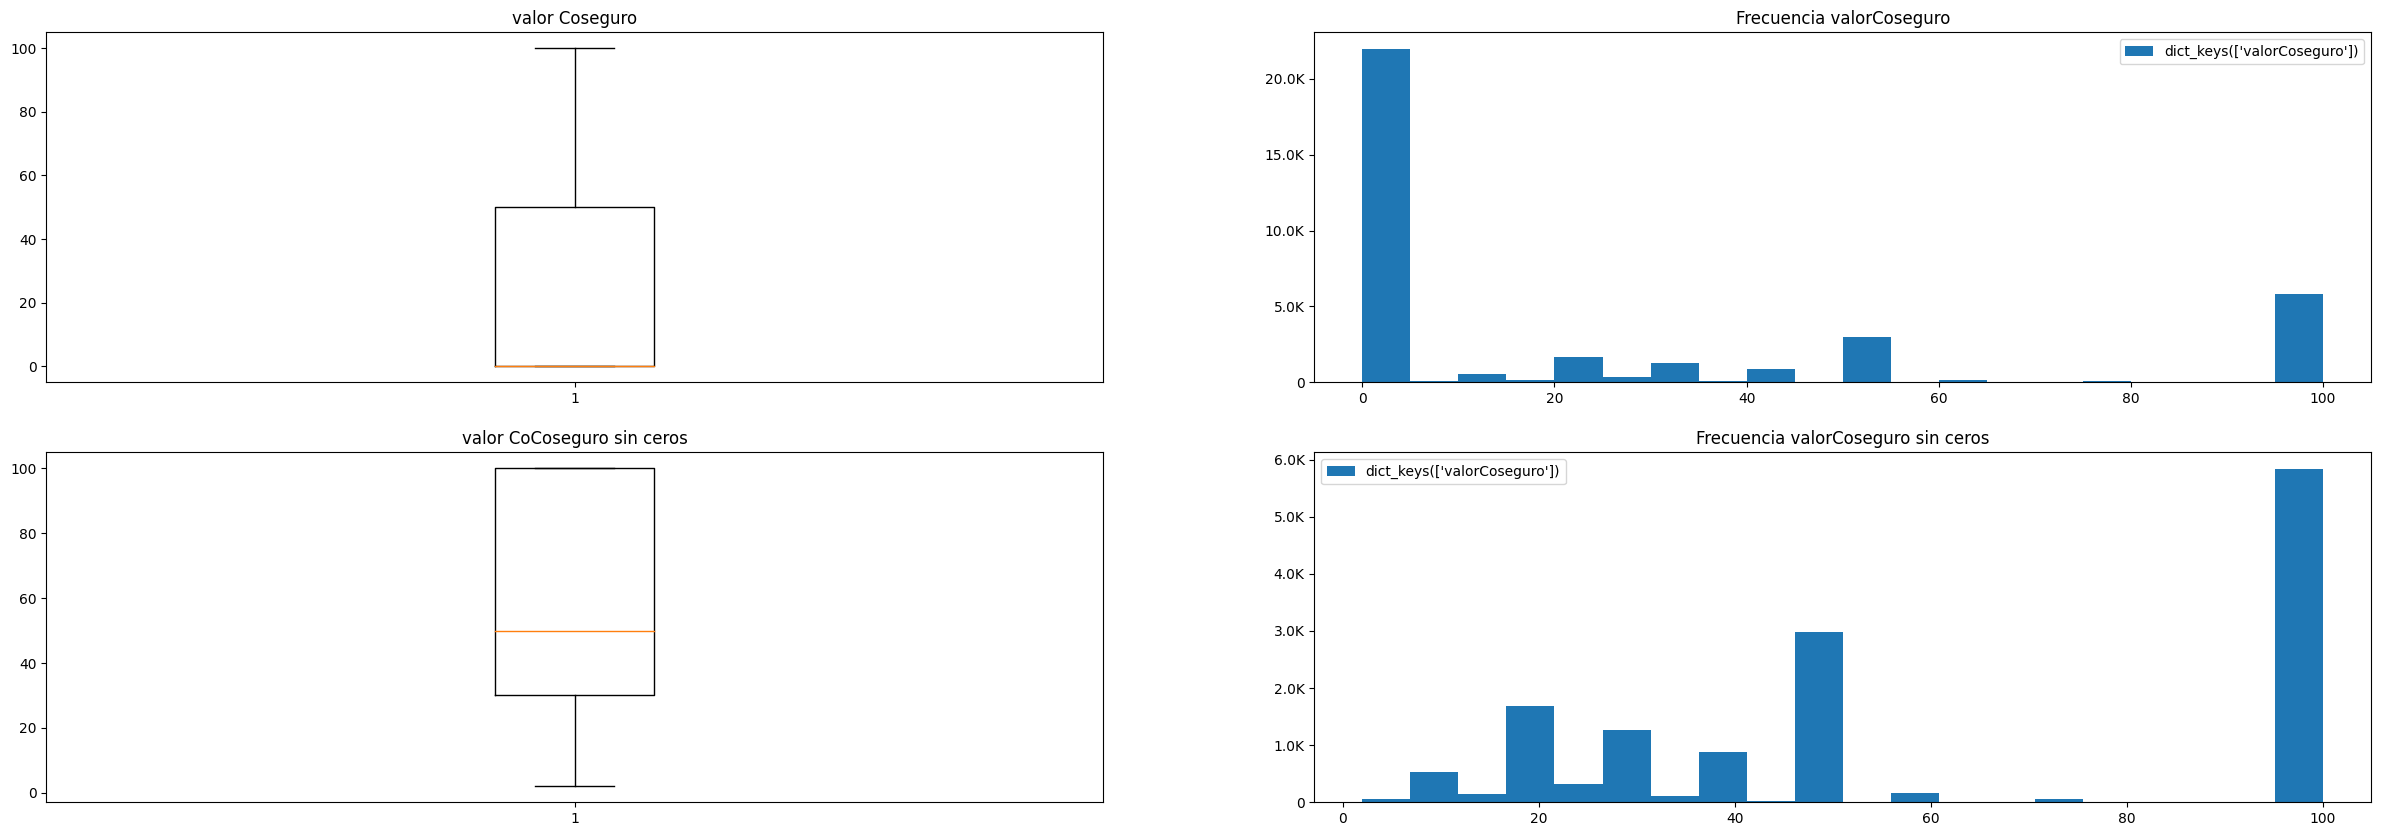

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(30, 10)
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

ax1.set_title('valor Coseguro')
ax1.boxplot(np.array(planes_beneficio.select('valorCoseguro').collect()))

hist(ax2, planes_beneficio.select('valorCoseguro'), bins = 20)
ax2.set_title('Frecuencia valorCoseguro')
ax2.legend()

ax3.set_title('valor CoCoseguro sin ceros')
ax3.boxplot(np.array(planes_beneficio.select('valorCoseguro').where(col('valorCoseguro') > 0).collect()))

hist(ax4, planes_beneficio.select('valorCoseguro').where(col('valorCoseguro') > 0), bins = 20)
ax4.set_title('Frecuencia valorCoseguro sin ceros')
ax4.legend()

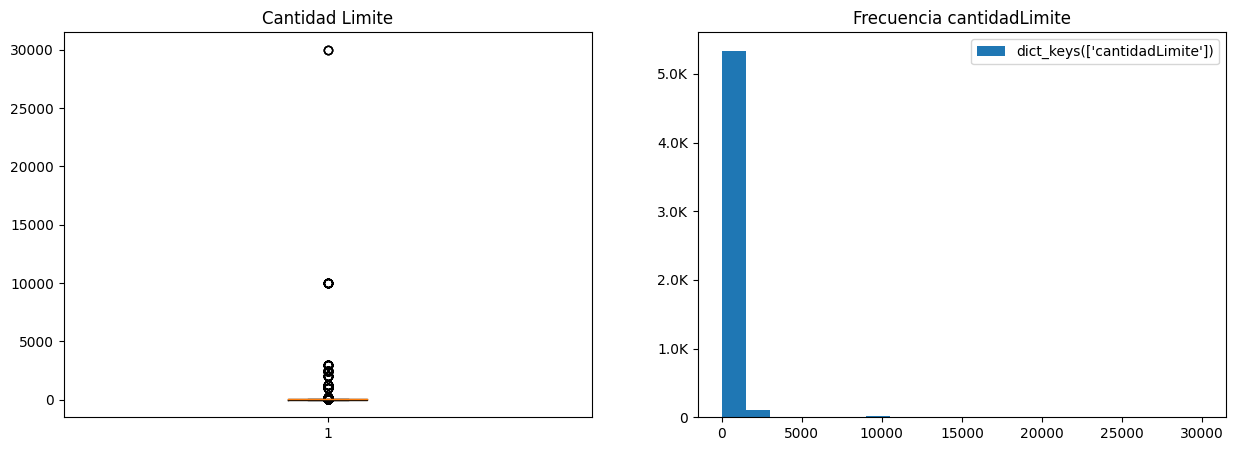

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)
ax1 = axes[0]
ax2 = axes[1]

ax1.set_title('Cantidad Limite')
ax1.boxplot(np.array(planes_beneficio.select('cantidadLimite').where(col('cantidadLimite').isNotNull()).collect()))

hist(ax2, planes_beneficio.select('cantidadLimite').where(col('cantidadLimite').isNotNull()), bins = 20)
ax2.set_title('Frecuencia cantidadLimite')
ax2.legend()

## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

### Completitud


In [35]:
def contar_nulos(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('    número de nulos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c] == "").count()
        if vacios!=0:
            print('    número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [36]:
for k,v in lista_tablas.items():
    print("TABLA: ", k)
    contar_vacios(v)
    contar_nulos(v)
    print("-"*100)

TABLA:  FuenteAreasDeServicio_Copia_E
    número de nulos para columna IdAreaDeServicio_T: 6288
    número de nulos para columna IdGeografia_T: 6378
    número de nulos para columna Area: 2407
    número de nulos para columna Densidad: 2407
----------------------------------------------------------------------------------------------------
TABLA:  FuenteTiposBeneficio_Copia_E
    número de vacíos para columna UnidadDelLimite: 559
----------------------------------------------------------------------------------------------------
TABLA:  FuentesPlanesBeneficio_Copia_E
    número de vacíos para columna IdPlan_T: 2053
    número de nulos para columna IdTipoBeneficio_T: 2086
    número de nulos para columna IdAreaDeServicio_T: 2041
    número de nulos para columna cantidadLimite: 30571
----------------------------------------------------------------------------------------------------
TABLA:  FuenteCondicionesDePago_Copia_E
------------------------------------------------------------------

In [37]:
sql = "(SELECT IdAreaDeServicio_T, count(distinct(NombreAreaDeServicio)) FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E GROUP BY IdAreaDeServicio_T) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+------------------+-------------------------------------+
|IdAreaDeServicio_T|count(distinct(NombreAreaDeServicio))|
+------------------+-------------------------------------+
|              null|                                 2697|
|             12018|                                    1|
|             42018|                                    1|
|             52018|                                    1|
|             62018|                                    1|
+------------------+-------------------------------------+
only showing top 5 rows



In [38]:
sql = "(SELECT * FROM RaSaTransaccional.FuenteTiposBeneficio_Copia_E WHERE UnidadDelLimite = '') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-----------------+--------------------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|               |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              200| Denture Adjustments|               |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              735|P

In [39]:
sql = "(SELECT * FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE IdTipoBeneficio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|             null|         107352017|                      238|                         45|                2|93332GA0710044-00|2017-12-31|        93332|          0|            0|          null|
|             null|          85992018|                      238|                         45|                2|71933PA0020003-00|2018-12-31|        71933|          0|            0|             1|
|             null|      

In [40]:
sql = "(SELECT * FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE cantidadLimite IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|          66252017|                      238|                         45|                1|52697WI0010002-00|2017-12-31|        52697|          0|            0|          null|
|              620|      

In [41]:
for k,v in lista_tablas.items():
    print("TABLA: ", k)
    columnas_alta_cardinalidad = cardinalidad(v)
    print("    Columnas con alta cardinalidad: ", columnas_alta_cardinalidad)
    print("-"*100)

TABLA:  FuenteAreasDeServicio_Copia_E
    Columnas con alta cardinalidad:  {}
----------------------------------------------------------------------------------------------------
TABLA:  FuenteTiposBeneficio_Copia_E
    Columnas con alta cardinalidad:  {}
----------------------------------------------------------------------------------------------------
TABLA:  FuentesPlanesBeneficio_Copia_E
    Columnas con alta cardinalidad:  {}
----------------------------------------------------------------------------------------------------
TABLA:  FuenteCondicionesDePago_Copia_E
    Columnas con alta cardinalidad:  {'IdCondicionesDePago_T': 23, 'Descripcion': 17}
----------------------------------------------------------------------------------------------------


Como podemos observar para **FuenteAreasDeServicio_Copia_E** las columnas IdAreaDeServicio_T, IdGeografia_T, Area y Densidad tienen 6288, 6378, 2307 nulos respectivamente. 
 - Para solventar esto para la columna IdAreaDeServicio_T, ¿Es apropiado  completar los valores nulos con base al NombreAreaDeServicio? Esto porque aparentemente los mismos nombres de area de servicio corresponden a los mismos ids.
 - Para solventar esto para la columna IdGeografia_T, ¿Es apropiado  completar los valores nulos con base al Condado? Esto porque el diccionario indica que el IdGeofrafia_T esta relacionado con el condado.
 - No encontramos como solventar los valores nulos en Area y Densidad. De ser necesarios y útiles para los análisis solicitamos al negocio proveer dicha información para las áreas que tienen estos valores en nulo.

Como podemos observar para **FuenteTiposBeneficio_Copia_E** la columna UnidadDelLimite tiene 559 nulos. Este hallazgo es correcto ya que los registros con vacíos tienen la columna TieneLimiteCuantitativo con valor 'No'. Se toma la decisión de volver los valores vacíos ("") en valores nulos para hacer más fácil su manejo.

Como podemos observar para **FuentesPlanesBeneficio_Copia_E** las columnas IdPlan_T, IdTipoBeneficio_T, IdAreaDeServicio_T y cantidadLimite tienen 2053, 2086, 2041, 30571 nulos o vacíos respectivamente. 
- Dados los vacíos de la columna IdPlan_T, no se logra entender el por qué sucede esto ya que un beneficio siempre debería estar asociado a un plan y no es posible deducir por las otras columnas cuál sería el plan asociado al beneficio. Por lo tanto, solicitamos al negocio nos entregue esta información o nos confirme, ¿que hacer con estos registros? ¿Podemos realizar la eliminación de estos registros?
- Dados los nulos de la columna IdTipoBeneficio_T, no se logra entender el por qué sucede esto ya que la granularidad del hecho se basa en el beneficio por lo tanto, no es posible deducir por las otras columnas cuál sería el beneficio asociado. Solicitamos al negocio nos entregue esta información o nos confirme, ¿que hacer con estos registros? ¿Podemos realizar la eliminación de estos registros?
- Dados los nulos de la columna IdAreaDeServicio_T, hemos llegado a la conclusión de que si un ID de la tabla de hechos viene vacío no tenemos como inferirlo con base a otras columnas de la misma tabla de hechos. Por lo tanto, así como en los 3 casos anteriores. Solicitamos al negocio nos entregue esta información o nos confirme, ¿que hacer con estos registros? ¿Podemos realizar la eliminación de estos registros?
- Para los nulos de cantidadLimite se concluye que tienen sentido pues los beneficios sin límite cuantitativo deben tener una cantidad límite igual a cero, que en este caso esta siendo representada por valores nulos.


Respecto a cardinalidad ninguna tabla registra una cardinalidad superior al 50% de variabilidad única en cada columna a excepción de la tabla **FuenteCondicionesDePago_Copia_E** en donde las columnas IdCondicionesDePago_T y Descripcion. Esto indica que los IDs únicos de las tablas diferentes a la tabla de hechos y la tabla CondicionesDePago tienen bastantes valores duplicados lo cuál confirmaremos más adelante.

### Unicidad, Completitud y Validez


La unicidad se revisó tras el entendimiento de qué es una fila de cada fuente compartida. Y la validez se reviso en el perfilamiento general y la verificación de las reglas de negocio de forma general, se puede concluir que aparentemente se presentan problemas de Unicidad en todas las fuentes entregadas puesto que se encuentran entidades duplicadas. Adicionalmente, en cuanto a completitud se evidencia que la información no se encuentra completa en las fuentes PlanesBeneficio y AreaDeServicio, puntualmente en las columnas: IdAreaDeServicio_T, IdGeografia_T, Area, Densidad, IdPlan_T y IdTipoBeneficio_T. Se solicita al negocio aclarar si es normal que se repitan los identificadores de IdAreaDeServicio_T en la fuente de AreasDeServicio y si es correcto que eliminemos los registros completamente duplicados en la tabla de hechos BeneficiosPlan ya que no tiene sentido tener dos beneficios exactamente iguales en todos sus campos. Por último, con respecto a la validez se evidencia hay columnas con formatos diferentes, por ejemplo las Fechas en las diferentes tablas aparecen en diferente formato.

### Consistencia

La consistencia estructural y semántica se revisó en el perfilamiento general y como conclusión se tienen varias inconsistencias en tipos de datos que difieren entre las llaves primarias de las tablas y la definición de las llaves foranéas que las referencian. Por ejemplo, IdAreaDeServicio_T es tipo INT en la tabla AreasDeServicio y en la tabla BeneficiosPlanes aparece como tipo BIGINT, esto es un claro ejemplo de inconsistencia estructural, además las restricciones de nulidad no se encuentran en las llaves primarias de las tablas. Asociado a la inconsistencia semántica se evidencia que no hay columnas con el mismo concepto y significado pero diferente nombre, la única que uno podría decir, pero, tiene sentido que tengan diferentes nombres es la columna de IdCondicionesDePago que en la tabla de BeneficiosPlanes aparece referenciada 2 veces con dos nombres, uno para las condiciones del coseguro y otro para las condiciones del copago, lo cuál tiene todo el sentido.

Adicionalmente, se encuentran los siguientes hallazgos:
- Algunos Ids de IdGeografía están relacionados a diferentes condados, ¿es esto normal? 
- La fecha no se encuentra como una dimensión sino como un atributo de la tabla de hechos.
- Tenemos variables que van a requerir ser cambiadas en su tipo de categorica a numerica para posteriores análisis. Por ejemplo UnidadDelLimite de la tabla FuenteTiposBeneficio_Copia_E.
- En la tabla de hechos FuentePlanesBeneficio_Copia_E se identifican dos referencias a fuentes de datos faltantes para IdNivelServicio y IdProveedor. Se solicita al negocio proveer dicha información o aclarar el por qué faltan. 
- Adicionalmente se tiene la duda del significado del Coseguro que involucra las variables (valorCoseguro, IdCondicionDePagoCoseguro_T) de la tabla FuentePlanesBeneficio_Copia_E. Se solicita aclaración al negocio.
- ¿Por qué si en el diccionario de datos aparecen las restricciones de claves principales y foraneas, al hacer ingeniería inversa de la base de datos y validar en el inspector de tablas, ninguna tiene restricciones de llaves foraneas (FK) y todos los campos pueden ser null, incluyendo el identificador principal (PK)?
- ¿Por qué los mismos identificadores en diferentes tablas salen con diferentes tipos?

In [42]:
sql = "(SELECT distinct(IdGeografia_T), count(distinct(NombreAreaDeServicio)),count(distinct(IdGeografia_T)),count(distinct(Condado)),count(distinct(Estado)) FROM RaSaTransaccional.FuenteAreasDeServicio_Copia_E where IdGeografia_T=12009 group by IdGeografia_T) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-------------+-------------------------------------+------------------------------+------------------------+-----------------------+
|IdGeografia_T|count(distinct(NombreAreaDeServicio))|count(distinct(IdGeografia_T))|count(distinct(Condado))|count(distinct(Estado))|
+-------------+-------------------------------------+------------------------------+------------------------+-----------------------+
|        12009|                                   87|                             1|                       2|                      2|
+-------------+-------------------------------------+------------------------------+------------------------+-----------------------+



In [44]:
sql = 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E'
areas_beneficio = obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd)

sql = 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E'
condiciones_pago = obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd)

sql = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'
planes_beneficio = obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd)

sql = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'
tipos_beneficio = obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd)


ids_areas_beneficio = set([x.IdAreaDeServicio_T for x in areas_beneficio.select('IdAreaDeServicio_T').collect()])
ids_condiciones_pago = set([x.IdCondicionesDePago_T for x in condiciones_pago.select('IdCondicionesDePago_T').collect()])
ids_tipos_beneficio = set([x.IdTipoBeneficio_T for x in tipos_beneficio.select('IdTipoBeneficio_T').collect()])

ids_areas_en_planesbeneficio = set([x.IdAreaDeServicio_T for x in planes_beneficio.select('IdAreaDeServicio_T').collect()])
ids_condiciones_copago_en_planesbeneficio = set([x.IdCondicionDePagoCopago_T for x in planes_beneficio.select('IdCondicionDePagoCopago_T').collect()])
ids_condiciones_coseguro_en_planesbeneficio = set([x.IdCondicionDePagoCoseguro_T for x in planes_beneficio.select('IdCondicionDePagoCoseguro_T').collect()])
ids_condiciones_en_planesbeneficio =  ids_condiciones_copago_en_planesbeneficio.union(ids_condiciones_coseguro_en_planesbeneficio)
ids_tipos_en_planesbeneficio = set([x.IdTipoBeneficio_T for x in planes_beneficio.select('IdTipoBeneficio_T').collect()])


In [53]:
print(len(ids_areas_en_planesbeneficio - ids_areas_beneficio) , '-' , len(ids_areas_beneficio - ids_areas_en_planesbeneficio))
round(len(ids_areas_en_planesbeneficio - ids_areas_beneficio) / len(ids_areas_en_planesbeneficio), 5) , round(len(ids_areas_beneficio - ids_areas_en_planesbeneficio) / len(ids_areas_beneficio),5)

1097 - 10


(0.16885, 0.00185)

In [54]:
print(len(ids_condiciones_en_planesbeneficio - ids_condiciones_pago) , '-' , len(ids_condiciones_pago - ids_condiciones_en_planesbeneficio))
round(len(ids_condiciones_en_planesbeneficio - ids_condiciones_pago) / len(ids_condiciones_en_planesbeneficio), 5) , round(len(ids_condiciones_pago - ids_condiciones_en_planesbeneficio) / len(ids_condiciones_pago),5)

0 - 4


(0.0, 0.17391)

In [55]:
print(len(ids_tipos_en_planesbeneficio - ids_tipos_beneficio) , '-' , len(ids_tipos_beneficio - ids_tipos_en_planesbeneficio))
round(len(ids_tipos_en_planesbeneficio - ids_tipos_beneficio) / len(ids_tipos_en_planesbeneficio), 5) , round(len(ids_tipos_beneficio - ids_tipos_en_planesbeneficio) / len(ids_tipos_beneficio),5)

108 - 0


(0.37762, 0.0)

Conclusiones de consistencia del contenido:

- La relación foranéa entre AreasDeServicio y PlanesBeneficio no es consistente pues hay 1097 areas en planes beneficio que no existen en la tabla areas de servicio.
- La relación foranéa entre CondicionesDePago y PlanesBeneficio es consistente pues todos las condiciones referenciadas en planes beneficio existen en la tabla de condiciones.
- La relación entre TiposBeneficio y PlanesBeneficio no es consistente ya que no se encontraron 108 identificadores de tipos de beneficio en su respectiva tabla que fueron referenciados en la tabla de PlanesBeneficio.

Adicionalmente, no se cuenta con las fuentes de NivelServicio y Proveedores referenciadas en la tabla de hechos PlanesBeneficio.

## Herramientas para facilitar el entendimiento de datos

In [56]:
reporte = ProfileReport(planes_beneficio.toPandas())
reporte.to_file(PATH+"reporte_perfilamiento_planesbeneficio.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Del reporte, adicional a lo ya mencionado podemos destacar:**

- Los identificadores de TipoBeneficio y AreaDeServicio son los que cuentan con más registros vacíos en la tabla de hechos con un porcentaje del 5.8% y 5.7% respectivamente.
- Se evidencia que el IdPlan_T tiene una alta cardinalidad, lo cuál hace sentido en esta tabla de hechos pues los beneficios se relacionan principalmente con este identificador.
- Se reafirma que las fechas tienen diferentes formatos.
- Los valores de copago y coseguro tienen 94.5% y 60.9% de valores en ceros. ¿Se quiere preguntar al negocio si esto es normal?
- En cantidad limite se encuentran 84.8% de registros vacíos lo cuál es correcto pues estos registros suponen no tener una cantidad limite en el beneficio.
- En esta tabla de hechos PlanBeneficio no tiene sentido revisar las correlaciones pues se trata de 7 identificadores, una fecha y 3 medidas.
- El valor promedio de copago y coseguro es de 9.78 y 24.3 dólares respectivamente. 
- El valor promedio de la cantidad límite es de 123.4

## Validación de análisis requeridos

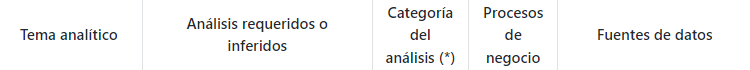

---------------------------------------------------------------------
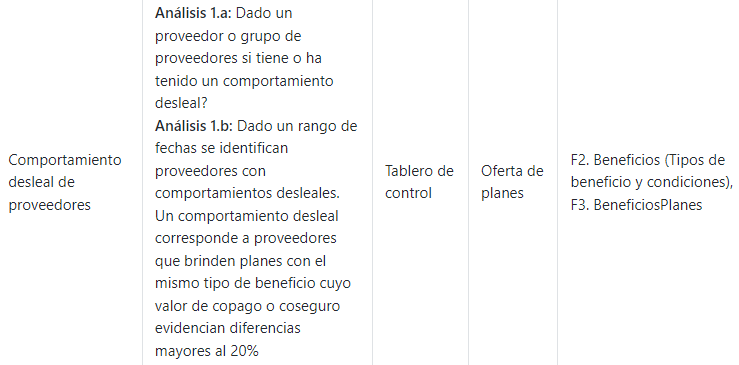

In [57]:
sql = "(SELECT Fecha,IdProveedor_T,IdTipoBeneficio_T, count(*) cuenta, min(valorCopago), max(valorCopago), min(valorCoseguro), max(valorCoseguro) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE valorCopago > 0 AND valorCoseguro > 0 AND IdTipoBeneficio_T = 175 GROUP BY Fecha,IdProveedor_T,IdTipoBeneficio_T) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------+-------------+-----------------+------+----------------+----------------+------------------+------------------+
|      Fecha|IdProveedor_T|IdTipoBeneficio_T|cuenta|min(valorCopago)|max(valorCopago)|min(valorCoseguro)|max(valorCoseguro)|
+-----------+-------------+-----------------+------+----------------+----------------+------------------+------------------+
| 2017-12-31|        36096|              175|     5|             400|            1500|                20|                50|
| 2017-12-31|        32753|              175|     3|             500|            1000|                50|                50|
| 2017-12-31|        87571|              175|     8|             250|            1500|                20|                50|
| 2017-12-31|        36239|              175|     3|             250|            1000|                50|                60|
| 2017-12-31|        33602|              175|     2|             200|            1500|                20|                50|


In [58]:
sql = "(SELECT distinct(Fecha), count(*) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E group by Fecha) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------+--------+
|      Fecha|count(*)|
+-----------+--------+
| 2017-12-31|   16134|
| 2018-12-31|   15794|
|Dec 31,2017|    1029|
|Dec 31,2018|    1027|
| 1920-12-31|    2052|
+-----------+--------+



De acuerdo con la información compartida en las tablas de Planes de Beneficio, es posible identificar los proveedores que presenten un comportamiento desleal, dentro de un rango de fechas para un beneficio puntual. Pese a lo anterior, es necesario realizar ajustes sobre la información compartida por el negocio, puntualmente para la fecha de los beneficios ya que 4107 registros se encuentran con información inconsistente en el formato, o en la fecha del beneficio tal como se pudo apreciar en el cuadro anterior. Adicionalmente, con la actual información solo se puede identificar a los proveedores por medio del ID, sin el nombre de estos. Le recomendamos al negocio compartirnos una tabla en la cual se incluya la información del ID del proveedor, junto con su nombre, con el fin de brindar interpretaciones más claras.

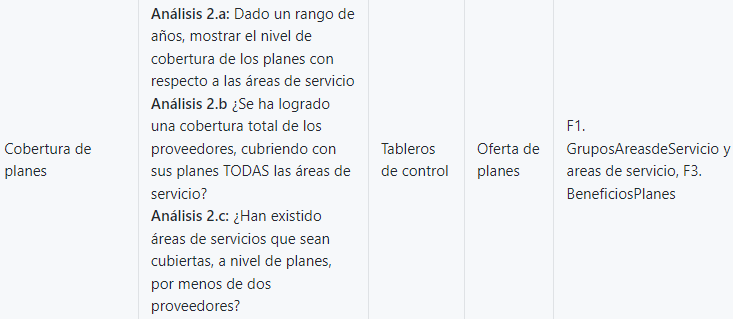

In [41]:
sql = "(SELECT a.idAreaDeServicio_T as idAreaServicio , p.* FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T  WHERE p.Fecha BETWEEN '1900-01-01' AND '2016-12-31') AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+--------------+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|idAreaServicio|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+--------------+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|      55212018|              130|          55212018|                       34|                         18|                1|41047OH0010019-04|1920-12-31|        41047|          0|            0|          null|
|      55212018|              130|          55212018|                       34|                         18|                1|41047OH0010019-04|1920-12-31|      

In [42]:
sql = "(SELECT distinct(p.Fecha) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-----------+
|      Fecha|
+-----------+
| 2017-12-31|
| 2018-12-31|
|Dec 31,2017|
|Dec 31,2018|
| 1920-12-31|
+-----------+



In [43]:
# Numero de beneficios con identificadores de area nulos
sql = "(SELECT COUNT(*) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E  WHERE IdAreaDeServicio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+--------+
|COUNT(*)|
+--------+
|    2041|
+--------+



In [44]:
# Numero de beneficios con referencias a areas no existentes
sql = "(SELECT COUNT(p.idAreaDeServicio_T) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T  WHERE a.IdAreaDeServicio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+---------------------------+
|COUNT(p.idAreaDeServicio_T)|
+---------------------------+
|                       4979|
+---------------------------+



In [45]:
# Numero de areas diferentes no existentes referenciadas por beneficios
sql = "(SELECT COUNT(distinct(p.idAreaDeServicio_T)) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T  WHERE a.IdAreaDeServicio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-------------------------------------+
|COUNT(distinct(p.idAreaDeServicio_T))|
+-------------------------------------+
|                                 1097|
+-------------------------------------+



In [46]:
# Numero de areas de servcio distintas que no tienen ningún beneficio o plan asociado
sql = "(SELECT COUNT(distinct(a.idAreaDeServicio_T)) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p RIGHT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T  WHERE p.idAreaDeServicio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show(5)

+-------------------------------------+
|COUNT(distinct(a.idAreaDeServicio_T))|
+-------------------------------------+
|                                   10|
+-------------------------------------+



In [47]:
# Areas de servicio distintas que no tienen ningún beneficio asociado
sql = "(SELECT distinct(a.idAreaDeServicio_T) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p RIGHT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T  WHERE p.idAreaDeServicio_T IS NULL) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+------------------+
|idAreaDeServicio_T|
+------------------+
|          45022018|
|          98092018|
|          51072017|
|          55102018|
|          64422017|
|          98312018|
|         100582017|
|              null|
|          95742017|
|         112102017|
|         101832017|
+------------------+



In [48]:
# Un plan cuantas áreas,condados y estados diferentes cubre en un rango de fechas
sql = """(
SELECT IdPlan_T , count(distinct(a.idAreaDeServicio_T)) as areas_cubiertas, count(distinct(a.Condado)) as condados_cubiertos, count(distinct(a.Estado)) as estados_cubiertos FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p 
JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T 
WHERE p.Fecha BETWEEN '1900-01-01' AND '2020-12-31' 
GROUP BY IdPlan_T ORDER BY estados_cubiertos DESC
) AS Compatible

"""
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------------+---------------+------------------+-----------------+
|         IdPlan_T|areas_cubiertas|condados_cubiertos|estados_cubiertos|
+-----------------+---------------+------------------+-----------------+
|                 |           1063|              1211|               34|
|10207VA0380001-06|              4|                 7|                1|
|10207VA0430006-01|              3|                 7|                1|
|10207VA0440004-00|              3|                 7|                1|
|11269WY0080014-00|             77|                23|                1|
|11512NC0060018-01|              1|                46|                1|
|11512NC0060024-01|              1|                76|                1|
|11512NC0060028-01|              1|                74|                1|
|11512NC0100022-00|              1|                20|                1|
|11512NC0100024-04|              1|                18|                1|
|11512NC0100024-06|              1|                

In [68]:
# Un área es cubierta por cuantos planes diferentes
sql = """(
SELECT a.idAreaDeServicio_T , count(distinct(p.IdPlan_T)) as cantidad_planes, count(distinct(p.IdProveedor_T)) as cantidad_proveedores_diferentes  FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p 
JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T 
GROUP BY idAreaDeServicio_T ORDER BY cantidad_planes DESC
) AS Compatible

"""
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+------------------+---------------+-------------------------------+
|idAreaDeServicio_T|cantidad_planes|cantidad_proveedores_diferentes|
+------------------+---------------+-------------------------------+
|             42018|              2|                              1|
|             52018|              2|                              1|
|            282017|              2|                              1|
|            402017|              2|                              1|
|            442017|              2|                              1|
|            452017|              2|                              1|
|            492017|              2|                              1|
|            512017|              2|                              1|
|            642017|              2|                              1|
|            712017|              2|                              1|
|            722017|              2|                              1|
|           1132018|              

In [50]:
# Un condado es cubierto por cuantos planes diferentes en un rango de fechas
sql = """(
SELECT a.Condado , count(distinct(p.IdPlan_T)) as cantidad_planes FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p 
JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T 
WHERE p.Fecha BETWEEN '1900-01-01' AND '2020-12-31' 
GROUP BY Condado ORDER BY cantidad_planes DESC
) AS Compatible

"""
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+-----------------+---------------+
|          Condado|cantidad_planes|
+-----------------+---------------+
|   Jackson County|             73|
| Jefferson County|             67|
|     Union County|             62|
|    Monroe County|             58|
|Washington County|             57|
|   Lincoln County|             54|
|     Wayne County|             54|
|Montgomery County|             50|
|    Marion County|             49|
|  Franklin County|             48|
|   Madison County|             45|
|     Adams County|             42|
|      Clay County|             41|
|   Clinton County|             41|
|    Warren County|             41|
|     Clark County|             39|
|  Crawford County|             38|
|    Greene County|             38|
|   Fayette County|             37|
|     Grant County|             37|
+-----------------+---------------+
only showing top 20 rows



In [51]:
# Un Estado es cubierto por cuantos planes diferentes en un rango de fechas
sql = """(
SELECT a.Estado , count(distinct(p.IdPlan_T)) as cantidad_planes FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p 
JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E as a ON  p.idAreaDeServicio_T = a.idAreaDeServicio_T 
WHERE p.Fecha BETWEEN '1900-01-01' AND '2020-12-31' 
GROUP BY Estado ORDER BY cantidad_planes DESC
) AS Compatible

"""
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+--------------+---------------+
|        Estado|cantidad_planes|
+--------------+---------------+
|      Illinois|             57|
|     Wisconsin|             56|
|         Texas|             36|
|      Michigan|             25|
|       Florida|             22|
|      Virginia|             18|
|          Ohio|             17|
|North Carolina|             15|
|  Pennsylvania|             14|
|     Louisiana|             11|
|      Oklahoma|             11|
|  North Dakota|              9|
|      Kentucky|              9|
|    New Jersey|              9|
|       Georgia|              8|
|    New Mexico|              8|
|South Carolina|              7|
|       Indiana|              7|
|      Missouri|              6|
|       Montana|              6|
+--------------+---------------+
only showing top 20 rows



In [69]:
# Cantidad de proveedores diferentes por área de servicio
sql = """(
SELECT p.idAreaDeServicio_T, count(distinct(p.IdProveedor_T)) as cantidad_proveedores FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E as p 
GROUP BY idAreaDeServicio_T ORDER BY cantidad_proveedores DESC
) AS Compatible

"""
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+------------------+--------------------+
|idAreaDeServicio_T|cantidad_proveedores|
+------------------+--------------------+
|              null|                  99|
|             12018|                   1|
|             42018|                   1|
|             52018|                   1|
|             62018|                   1|
|             82018|                   1|
|            112018|                   1|
|            122018|                   1|
|            142018|                   1|
|            152018|                   1|
|            162018|                   1|
|            242017|                   1|
|            252017|                   1|
|            262017|                   1|
|            272017|                   1|
|            282017|                   1|
|            292017|                   1|
|            302017|                   1|
|            312017|                   1|
|            322017|                   1|
+------------------+--------------

Hallazgos:
- Las fechas no están estandarizadas en un mismo formato ni son tipo fecha esto impide realizar el filtro de años correctamente para todos los valores.
- Al realizar la unión de las tablas GruposAreasdeServicio y BeneficiosPlanes encontramos que hay 2041 beneficios con identificadores de áreas nulos y 4979 beneficios que tienen referenciados 1097 identificadores de áreas de servicio no existentes.
- Al realizar la unión de las tablas GruposAreasdeServicio y BeneficiosPlanes encontramos que hay 10 áreas de servicio que no están asociadas con ningún beneficio. Esto quiere decir que no todas las áreas de servicio están cubiertas por un plan (en este caso faltan 10 áreas por cubrir) - 2B
- No hay beneficios que tengan cobertura en más de 1 estado. ¿Es esto normal, que la cobertura de un plan no sea entre estados?
- Todas las áreas de servicio están asociadas a máximo dos planes. ¿Esto es un supuesto válido o simplemente casualidad en los datos? 
- Para cada área de servicio hay máximo un proveedor diferente asociado. - 2C ¿Esto es un supuesto válido o simplemente casualidad en los datos? 
 
Es posible realizar estos análisis de forma correcta si:
- Se estandariza el formato de las fechas para que el filtro funcione con todos los registros y para mayor fácilidad, crear la dimensión Fecha. 
- Se solicita al negocio completar la información faltante o aclarar el supuesto a tomar para este análisis, por ejemplo: No tomar en cuenta estos registros de beneficios con valores de áreas nulos o referencias no existentes a la tabla de áreas.
- El negocio aclara si quiere ver que la cobertura de los planes por áreas (id de área), estado, condado o todas las anteriores.
- Se corrigen algunas áreas que tienen identificadores nulos.
- Se corrigen los beneficios que tienen identificadores de plan vacíos.



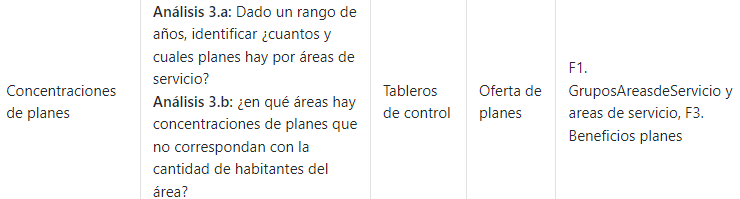

In [79]:
sql = "(SELECT Fecha, IdAreaDeServicio_T, count(distinct(IdPlan_T)) FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E WHERE Fecha LIKE '%2017%' or '%2018%' group by Fecha, IdAreaDeServicio_T order by count(distinct(IdPlan_T)) desc ) AS Compatible"
obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd).show()

+----------+------------------+-------------------------+
|     Fecha|IdAreaDeServicio_T|count(distinct(IdPlan_T))|
+----------+------------------+-------------------------+
|2017-12-31|              null|                      102|
|2017-12-31|            282017|                        2|
|2017-12-31|            402017|                        2|
|2017-12-31|            442017|                        2|
|2017-12-31|            452017|                        2|
|2017-12-31|            492017|                        2|
|2017-12-31|            512017|                        2|
|2017-12-31|            642017|                        2|
|2017-12-31|            712017|                        2|
|2017-12-31|            722017|                        2|
|2017-12-31|           1232017|                        2|
|2017-12-31|           1742017|                        2|
|2017-12-31|           1802017|                        2|
|2017-12-31|           1822017|                        2|
|2017-12-31|  

**3.a** En este caso, al completar la información del área de servicio correctamente y ajustar el formato de los registros que tiene un formato incorrecto, se podrá para un rango de años identificar la cantidad de planes por área de servicio.

**3.b** Para poder realizar el análisis que el cliente solicita, primero se selecciona la fuente de datos y las columnas con las que se trabajará. En este caso, como se habla de concentración de planes por área de servicio, se piensa inicialmente en trabajar sobre la tabla de hechos, específicamente con las columnas IdAreaDeSercivio_T e IdPlan_T. Ya que relacionan el identificador del área de servicio y del plan de beneficios. 

No obstante, en la tabla de hechos no existe información sobre la cantidad de habitantes por área, por lo que se recure a realizar una unión con la tabla FuenteAreasDeServicio_Copia_E, que contiene información sobre la cantidad de habitantes en la columna PoblacionAct. Se realiza un LEFT JOIN, teniendo a la izquierda la tabla de hechos y a la derecha la tabla de áreas de servicios, uniendolas por "IdAreaDeServicio_T". 

Una vez disponible la información, lo que se quiere evidenciar son aquellos planes en donde la cantidad de habitantes sea diferente para el mismo plan. De acuerdo al análisis de la información dada realizado hasta ahora, se asocia la cantidad de población no solo al área de servicios sino al Condado, por lo que de la únion se tomarán para el calculo el Condado y la población actual. Para esto se generá un conteo de valores únicos de poblacioenes, agrupando los datos para el cálculo, primero por el identificador de área,luego por el identificador del plan y finalmente por el condado. 

A continuación se presenta el query y el resultado obtenido:

In [88]:
query_3b = """(WITH conteo AS (SELECT  planes.IdAreaDeServicio_T AS IdAreas,
		planes.IdPlan_T AS IdPlan,
		areas.Condado AS Condado,
		count(distinct(areas.PoblacionAct)) AS Conteo_Poblacion
 FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E AS planes
 LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E AS areas
 ON planes.IdAreaDeServicio_T = areas.IdAreaDeServicio_T
 GROUP BY IdAreas, IdPlan, Condado
 ORDER BY IdAreas ASC, Condado ASC)
 
SELECT IdAreas,
		IdPlan,
        Condado,
        Conteo_Poblacion
FROM conteo 
WHERE Conteo_Poblacion > 1
 GROUP BY IdAreas, IdPlan, Condado
 ORDER BY IdAreas ASC, Condado ASC) AS Compatible
 """
obtener_dataframe_de_bd(db_connection_string, query_3b, db_user, db_psswd).show(5)

+-------+-----------------+---------------+----------------+
|IdAreas|           IdPlan|        Condado|Conteo_Poblacion|
+-------+-----------------+---------------+----------------+
| 122018|10207VA0430006-01| Loudoun County|               2|
| 362017|11269WY0080014-00|Sublette County|               2|
| 382017|11269WY0080014-00|  Platte County|               2|
| 432017|11269WY0080014-00| Johnson County|               2|
| 472017|11269WY0080014-00|Sublette County|               2|
+-------+-----------------+---------------+----------------+
only showing top 5 rows



In [86]:
query_3b = """(WITH conteo AS (SELECT  planes.IdAreaDeServicio_T AS IdAreas,
		planes.IdPlan_T AS IdPlan,
		areas.Condado AS Condado,
        areas.PoblacionAct as Poblacion,
		count(distinct(areas.PoblacionAct)) AS Conteo_Poblacion
 FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E AS planes
 LEFT JOIN RaSaTransaccional.FuenteAreasDeServicio_Copia_E AS areas
 ON planes.IdAreaDeServicio_T = areas.IdAreaDeServicio_T
 GROUP BY IdAreas, IdPlan, Condado, Poblacion
 ORDER BY IdAreas ASC, Condado ASC)
 
SELECT IdAreas,
		IdPlan,
        Condado,
        Poblacion,
        Conteo_Poblacion
FROM conteo 
WHERE Conteo_Poblacion = 1
 GROUP BY IdAreas, IdPlan, Condado, Poblacion
 ORDER BY Poblacion DESC) AS Compatible
 """
obtener_dataframe_de_bd(db_connection_string, query_3b, db_user, db_psswd).show()

+--------+-----------------+-----------------+----------+----------------+
| IdAreas|           IdPlan|          Condado| Poblacion|Conteo_Poblacion|
+--------+-----------------+-----------------+----------+----------------+
|29152018|29418TX0140002-04|    Harris County|4.72803E10|               1|
|25712018|27248TX0010008-02|    Harris County|4.72803E10|               1|
|27322018|27248TX0010008-02|    Harris County|4.72803E10|               1|
|19772017|21663FL0130009-01|Miami-Dade County|2.66278E10|               1|
|19772017|                 |Miami-Dade County|2.66278E10|               1|
|10452017|16842FL0070128-03|Miami-Dade County|2.66278E10|               1|
|10062017|16842FL0070128-03|Miami-Dade County|2.66278E10|               1|
|24942017|                 |    Dallas County|2.58605E10|               1|
|24942017|26250TX0050004-00|    Dallas County|2.58605E10|               1|
|29342017|29418TX0140002-04|    Dallas County|2.58605E10|               1|
|29722018|29418TX0140002-

Para presentar únicamente aquellas área de servicio en donde los planes no corresponden con la cantidad de población actual, debido a que presentan más de un dato de población, se utiliza un subquery filtrando el conteo por valores superiores a 1. 

De acuerdo al resultado, es posible realizar el análisis sobre la información dada si el negocio nos aclara cuál es la regla de correspondencia entre población y cantidad de planes. Aquí es importante tener en cuenta que el hecho de que existan dos cantidades de poblaciones para una misma área de servicios y un mismo condado, refiere que la información no es consistente, información que se consultará con el cliente.

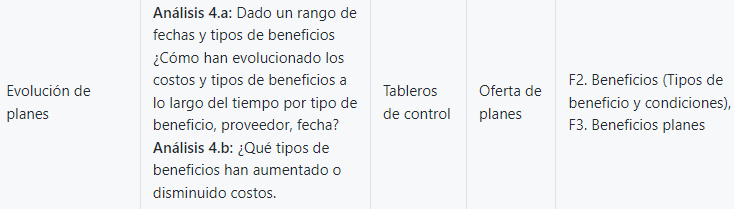

**4.a** Para este análisis se solicita tener un trazabilidad a lo largo del tiempo, del cambio en los costos para tipo de beneficio, por proveedor. Se trabajará con la información de la tabla de hecho, específicamente con la columna IdTipoBeneficio_T, IdProveedor_T, Fecha y como costos se tomarán por separado las columnas valorCopago y valorCoseguro. 

El rango de fecha y tipos de beneficios se tienen en cuenta dentro de la consulta con la sentencia WHERE. Para visualizar el incremento de precios a lo largo del tiempo bajo los requerimientos dados, se hace una agrupación primero por el identificador del beneficio, después por el proveedor, la fecha y por último, los costos. 

El query utilizado es:

In [92]:
query_4a = """(SELECT
		IdTipoBeneficio_T,
		IdProveedor_T,
		CASE WHEN str_to_date(Fecha , '%Y-%m-%d') IS NULL THEN  str_to_date(Fecha, '%M %e, %Y')
        ELSE   str_to_date(Fecha , '%Y-%m-%d')
        END AS Fecha,
        valorCopago,
        valorCoseguro
 FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E
 WHERE IdTipoBeneficio_T IN (990) AND Fecha BETWEEN '1990-01-01' AND '2018-05-05'
 GROUP BY  IdTipoBeneficio_T, IdProveedor_T, Fecha, valorCopago, valorCoseguro
 ORDER BY Fecha ASC, IdProveedor_T ASC) AS Compatible"""
obtener_dataframe_de_bd(db_connection_string, query_4a, db_user, db_psswd).show()

+-----------------+-------------+----------+-----------+-------------+
|IdTipoBeneficio_T|IdProveedor_T|     Fecha|valorCopago|valorCoseguro|
+-----------------+-------------+----------+-----------+-------------+
|              990|        11269|2017-12-31|          0|            0|
|              990|        11269|2017-12-31|          0|           25|
|              990|        11512|2017-12-31|          0|           20|
|              990|        11512|2017-12-31|          0|           50|
|              990|        11512|2017-12-31|          0|            0|
|              990|        14002|2017-12-31|          0|           50|
|              990|        16842|2017-12-31|          0|           20|
|              990|        21663|2017-12-31|          0|            0|
|              990|        21663|2017-12-31|          0|          100|
|              990|        29418|2017-12-31|          0|           20|
|              990|        29418|2017-12-31|          0|          100|
|     

Como se puede observar en el query. Para este ejemplo se tomo como tipo de beneficio el 990, y el rango de fechas esta dando entra el primero de enero de 1990 y el cinco de mayo de 2018. 

Al ejecutar el query es posible observar los cambios que han tenido los costos a medida que avanza el tiempo para uno o más beneficios a lo largo del tiempo, por lo que se cree poder responder a este análisis a través de esta consulta.

**4.b** Para este análisis se trabaja sobre la tabla de hechos con el identificador del tipo de beneficio, la fecha (extrayendo de está el año, ya que a los planes de beneficios se accede anualmente), valor del copago y de coseguro.

Como lo que se quiere conocer es la variación de los costos de un tipo de beneficios a través del tiempo, se calcula un promedio para los costos, facilitando así la identificación de la variación. Sí el promedio aumenta o disminiye de un año a otro, se tendrá un aumento o disminución en los costos.

Se agrupa por el identificador del beneficio, el área de servicio y posteriormente por la fecha. Obteniendo el promedio de costos para cada tipo de beneficio y siendo posible comparar su variación al avanzar en la línea de tiempo. Sí se quiere ver la variación sobre un tipo de beneficio específico, se puede generar una sentencia WHERE.

El query obtenido para el análisis es:

In [106]:
query_4b = """ (SELECT
		IdTipoBeneficio_T,
        IdAreaDeServicio_T,
        CASE WHEN str_to_date(Fecha , '%Y-%m-%d') IS NULL THEN EXTRACT(YEAR FROM str_to_date(Fecha, '%M %e, %Y'))
        ELSE  EXTRACT(YEAR FROM str_to_date(Fecha , '%Y-%m-%d'))
        END AS Fecha,
        ROUND(AVG(valorCopago),2) AS prom_Copago,
        ROUND(AVG(valorCoseguro),2) AS prom_Coseguro
 FROM RaSaTransaccional.FuentePlanesBeneficio_Copia_E
 GROUP BY  IdTipoBeneficio_T,IdAreaDeServicio_T, Fecha
 ORDER BY Fecha ASC, IdTipoBeneficio_T ASC) AS Compatible
 """
obtener_dataframe_de_bd(db_connection_string, query_4b, db_user, db_psswd).show()

+-----------------+------------------+-----+-----------+-------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|Fecha|prom_Copago|prom_Coseguro|
+-----------------+------------------+-----+-----------+-------------+
|                5|          38022018| 1920|       0.00|         0.00|
|                5|          67942018| 1920|       0.00|         0.00|
|                5|         109602017| 1920|       0.00|        30.00|
|                5|          71532018| 1920|       0.00|         0.00|
|                5|         114112017| 1920|       0.00|         0.00|
|                5|          38042018| 1920|       0.00|         0.00|
|                5|           2392017| 1920|       0.00|         0.00|
|                5|          51332017| 1920|       0.00|         0.00|
|                5|         108922018| 1920|       0.00|         0.00|
|                5|          28072018| 1920|       0.00|         0.00|
|                5|          39102017| 1920|       0.00|         0.00|
|     

Al intentar realizar el query, se evidencia que es necesario tener más información sobre como se desea agrupar los copagos y coseguros dado un tipo de beneficio en un rango de años puesto que el enunciado por si sólo no nos permite relacionar los costos ya que para un beneficio existen muchas ofertas en un mismo periodo de tiempo con diferentes costos de copago y coseguro. Se solicita el negocio esta información y la definición de las reglas con base en las que se ajustan los costos de los diferentes beneficios.

## Conclusiones/resultados

**Conclusiones generales:**

- El negocio nos comparte información relacionada a 4 fuentes. De las cuáles logramos inferir que:
    - FuenteAreasDeServicio_Copia_E --> Una fila de esta tabla representa una zona geográfica sobre la cuál se puede tener cobertura en un beneficio. Un registro tiene información identificador del área, su nombre, la fecha de creación, el identificador del condado, los nombres del estado y del condado e información de población, área y densidad de habitantes de la cobertura.
    - FuenteCondicionesDePago_Copia_E --> Una fila de esta tabla representa el tipo de pago y la descripción de las condiciones del pago.
    - FuentesPlanesBeneficio_Copia_E --> Una fila de esta tabla representa un beneficio asociado a un plan y unas caracteristicas del beneficio como el tipo, el area de servicio, las condiciones de copago y coseguro, el proveedor que lo suministra, el nivel de servicio, la fecha de oferta del beneficio para ese plan, los valores de copago y coseguro y la cantidad limite del tipo de beneficio.
    - FuenteTiposBeneficio_Copia_E --> Una fila de esta tabla representa el tipo de beneficio, su nombre, la unidad límite y si la tiene, si se cubre dentro de la red, si esta excluido del desembolso dentro o fuera de la red y las condiciones de este beneficio (si es escencial, lo cubre el seguro, etc.)

- Se requiere que el negocio realice aclaraciones sobre las fuentes de datos y las columnas de las mismas puesto que se encontraron inconsistencias, hallazgos en las llaves y atributos de las tablas que no corresponden con el diccionario de datos.

- También es necesario que el negocio entregue datos faltantes y tablas de referencia importantes para construir tableros de calidad como lo son las tablas de proveedores y nivel de servicio.

**Conclusiones de reglas de negocio:**

1. Las áreas de servicios reportadas corresponden a todas la áreas del país -- Esta afirmación es falsa. Hay 1.398 Condados con áreas de servicio reportadas de 3.143 que posee Estados Unidos. Adicionalmente esta regla no se cumple al validar el número de Estados que reporta 35 de 50 que tiene Estados Unidos. --

2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen -- Esta afirmación es verdadera como se puede evidenciar en la siguiente consulta. (La cantidad mínima cuando hay límite cuantitativo es de 1) --

3. Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019 -- Esta afirmación es falsa pues para FuenteAreasDeServicio_Copia_E el rango de la fecha del año 1800 al año 2018 y para FuenteTiposBeneficio_Copia_E este mismo rango es del año 2017 al año 2018 --

4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios. -- Esta afirmación es verdadera para las áreas de servicio pero falsa para los tipos de beneficios ya que hay 178. --

5. El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100. -- Esta afirmación es verdadera para valor Coseguro y falsa para Copago en donde el valor máximo es de 3500 --

6. Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018. -- Esta afirmación es falsa pues se tiene información de 203 planes para 2017 y 287 planes para 2018. --

7. Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente. -- Esta afirmación es falsa pues se tienen 19 y 7 condiciones de copago y coseguro respectivamente. --

De las 7 reglas de negocio compartidas se evidencia que solo hay una completamente verdadera y las otras son completamente o parcialmente falsas. Solicitamos al negocio aclarar el porque los datos no reflejan lo que aseguran o validar las fuentes de la información entregada.

**Conclusiones de calidad:**

Los datos presentan varios registros duplicados en todas las fuentes, y en algunas presentan vacíos y nulos en términos de completitud y unicidad. Adicionalmente, para los rangos de fechas es necesario la transformación de las columnas Fecha puesto que se tienen diferentes formatos al deseado y se requieren realizar rangos de fechas en el Tablero de Control solicitado. Con respecto a la consistencia se evidencian bastantes problemas en las relaciones con los identificadores por ejemplo: 1097 Ids de AreaDeServicio referenciados en la tabla de PlanesBeneficio no se encuentran en la tabla de AreasDeServicio, lo cuál dificultaría en este caso, la realización del análisis de cobertura de planes por áreas de servicio. Si realizamos la eliminación de las filas de los registros con inconsistencias en alguna de las columnas podríamos estar perdiendo aproximadamente el 10% del total de información compartida, por lo tanto consideramos que lo ideal es que el negocio nos ayude a subsanar estas inconsistencias en la información sin recurrir a la eliminación. Se solicita al negocio revisar, confirmar o justificiar que hacer con las supocisiones entregadas a lo largo de este ejercicio sobre las dimensiones y la tabla de hechos.

**Usando herramientas:**

Se requiere que el negocio participe del análisis descriptivo de las variables de la tabla de hecho con el fin de validar que los hallazgos corresponden con el conocimiento que ellos tienen del negocio o si hay algo que pareciera no ser consistente. Se solicita al negocio validar que la información reportada sobre los promedios y tendencias de las medidas corresponde a la realidad del negocio.

**Conclusiones de consultoria / requerimientos**

Se evidencia que es posible resolver los requerimientos siempre y cuando se aclaren las inconsistencias que podrían dar lugar a malos reportes y los supuestos necesarios para dar claridad a lo que se va a presentar en los tableros de constrol (Estos supuestos pueden ser los recomendados en este entendimiento de datos o los que el negocio otorgue). Adicionalmente es muy relevante que el negocio nos entregue mayor información sobre las reglas y comportamientos que deben reflejar los datos, por ejemplo, la correspondencia entre cantidad de planes y población por área de servicio, las reglas o condiciones de actualización de precios de planes, entre otros. No está demás recordar la importancia de las fuentes faltantes que podrían enriquecer la información del tablero como la tabla de proveedores, geografías y niveles de servicio.